# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1, 'scripts/')  # TODO: insert at 1, 0 is the script path (or '' in REPL)

from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import shutil
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'  # BUG WITH MATLIBPLOT KERNAL HANG (https://github.com/dmlc/xgboost/issues/1715)
import pprint 
import matplotlib.pyplot as plt
%matplotlib inline

from ppo_agent import PPO_Agent
from params import Params
from logger import Logger
from CustomSummaryWriter import CustomSummaryWriter

In [3]:
# Time related Utilities
from datetime import datetime
import pytz

def get_time(format):
    utc_now = pytz.utc.localize(datetime.utcnow())
    pst_now = utc_now.astimezone(pytz.timezone("Asia/Singapore"))   # Set to your own timezone: pytz.all_timezones
    return pst_now.strftime(format)

def total_train_duration(start_time, end_time):
    duration = end_time - start_time              # For build-in functions
    duration_in_s = duration.total_seconds()      # Total number of seconds between dates
    days    = divmod(duration_in_s, 86400)        # Get days (without [0]!)
    hours   = divmod(days[1], 3600)               # Use remainder of days to calc hours
    minutes = divmod(hours[1], 60)                # Use remainder of hours to calc minutes
    seconds = divmod(minutes[1], 1)               # Use remainder of minutes to calc seconds
    print("TOTAL TRAINING DURATION: %d days, %d hours, %d minutes and %d seconds" % (days[0], hours[0], minutes[0], seconds[0]))

In [4]:
# WARN: SLOWS DOWN TRAINING ALOT..
# torch.autograd.set_detect_anomaly(True)
# np.seterr(all='raise')

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [4]:
env = UnityEnvironment(file_name='Crawler_Windows_x86_64/Crawler.exe', worker_id=109)
# env = UnityEnvironment(file_name='Crawler_Windows_x86_64/Crawler.exe', no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: CrawlerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 129
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 20
        Vector Action descriptions: , , , , , , , , , , , , , , , , , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 12
Size of each action: 20
There are 12 agents. Each observes a state with length: 129
The state for the first agent looks like: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.25000000e+00
  1.00000000e+00  0.00000000e+00  1.78813934e-07  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.06093168e-01 -1.42857209e-01 -6.06078804e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.33339906e+00 -1.42857209e-01
 -1.33341408e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.0609

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [8]:
# env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
# states = env_info.vector_observations                  # get the current state (for each agent)
# scores = np.zeros(num_agents)                          # initialize the score (for each agent)

# while True:
#     actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#     actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#     env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#     next_states = env_info.vector_observations         # get next state (for each agent)
#     rewards = env_info.rewards                         # get reward (for each agent)
#     dones = env_info.local_done                        # see if episode finished
#     scores += env_info.rewards                         # update the score (for each agent)
#     states = next_states                               # roll over states to next time step
#     if np.any(dones):                                  # exit loop if episode finished
#         break
# print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [9]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

While training is taking place, statistics on agent performance are available from Tensorboard. To launch it use:
```python
cd <PROJECT_DIR>
tensorboard --logdir=runs
```

In [7]:
def ppo(params=Params(), logger=Logger()):

    print ("***STARTED TRAINING AT {} \n".format(get_time('%Y-%m-%d--%H:%M:%S')))
    start_time  = datetime.now() 
    env_info = env.reset(train_mode=True)[brain_name]
    action_size = brain.vector_action_space_size
    state_size = env_info.vector_observations.shape[1]
    logger.initialize(agent, state_size, action_size)
    
    try:
        start_eps = params.eps_to_resume_from if not params.restart_training else 1        
        for i_episode in range(start_eps, params.n_episodes+1):
            env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
            states = env_info.vector_observations              # get the current state
            score = np.zeros(len(env_info.agents))
            hasNaN = False

            for t in range(params.max_t):                             

                # REPORT NAN STATES
                if np.isnan(states).any():
                    print('\nNaN found in states. Skipping this episode.')
                    hasNaN = True
                    break

                # Perform actions from each agent's policy network (clipped actions [0, -1])  
                actions, log_probs, _, values = agent.act(states, agent.std_scale)
                env_info = env.step(actions)[brain_name]      
                next_states, rewards, dones = env_info.vector_observations, env_info.rewards, env_info.local_done

                # REPORT NAN ACTIONS
                if np.isnan(next_states).any():
                    print("NaN next_states Found! Skipping this episode.")
                    hasNaN = True
                    break

                if np.isnan(actions).any():
                    print('NaN found in actions. Skipping this episode.')
                    hasNaN = True
                    break

                if np.isnan(rewards).any():
                    print("NaN Reward Found! Skipping this episode.")
                    hasNaN = True
                    break

                # Only collect and learn from subset of data from episode (representative enough)
                if t < params.num_steps_collect_data:
                    agent.step(states, actions, rewards, log_probs, values, dones)
                    last_states = next_states

                # Allow crawler to keep resetting if fall (score -> 0)
                # Continue to accumulate score over entire duration max_t to maxmimize observable score
                states = next_states
                score += np.array(rewards)             
                for i in range(len(dones)):
                    if dones[i]:
                        logger.log_score(score[i])
                        score[i] = 0

                # Break if all agents are done (auto @ step=1000)
                if all(dones):   # any()
                    break 

            if not hasNaN:
                # Learn from episode (add last state if using GAE)
                agent.add_last_state(last_states)
                agent.learn()

                # Print crucial results for progress tracking
                logger.log_stats(i_episode, agent.actor_loss, agent.critic_loss, agent.entropy_loss)
                logger.log_decaying_hparams(i_episode, agent.lr, agent.eps, agent.beta, agent.std_scale)
                print('\rEpisode {}\t Score [This Eps]: {:.2f} \t Steps: {}'.format(i_episode, logger.scores_list[-1], t), end="")

                if i_episode % params.save_every == 0:
                    logger.save_weights(i_episode)

                if i_episode % params.print_every == 0:
                    print('\rEpisode {}: \tActor Loss: {:.2f} \tCritic Loss: {:.2f} \n\t\tAvg Score [100eps]: {:.2f} \t Steps: {}\n'
                          .format(i_episode, np.mean(logger.actor_loss_deque), np.mean(logger.critic_loss_deque), logger.scores_list[-1], t))

                    if logger.scores_list[-1] >= params.target_score:
                        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'
                              .format(i_episode, logger.scores_list[-1]))
                        if params.terminate_on_target_score:
                            break

        # Plot graphs & save final weights
        logger.save_weights(i_episode)
        if params.plot_stats:
            logger.plot_stats()
        logger.log_overall_perf_tb()
        total_train_duration(start_time=start_time, end_time=datetime.now())
        print ("***TRAINING STOPPED AT {} ".format(get_time('%Y-%m-%d--%H:%M:%S')))

    # Catch any exceptions (Esp with keyboard interrupts)
    except BaseException as error:
        print('\n\n==== An exception occurred: {}'.format(error))
        #logger.print_weights()
        logger.save_weights(i_episode)
        #if params.plot_stats:
        #    logger.plot_stats()
        logger.log_overall_perf_tb()
        total_train_duration(start_time=start_time, end_time=datetime.now())
        print ("***TRAINING STOPPED AT {} ".format(get_time('%Y-%m-%d--%H:%M:%S')))
    
    return logger.scores_list


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  1
BATCH_SIZE:  2048
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
GAMMA:  0.95
LR (Joint):  0.0001
LR_DECAY:  0.995
LR_MIN:  1e-05
BETA:  0.01
BETA_DECAY:  0.999
BETA_MIN:  0.001
EPS:  0.2
EPS_DECAY:  0.9975
EPS_MIN:  0.05
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.95
GRAD_CLIP:  1.0




============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  0
BATCH_SIZE:  2048
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
GAMMA:  0.95
LR (Joint):  0.0001
LR_DECAY:  0.995
LR_MIN:  1e-05
BETA:  0.01
BETA_DECAY:  0.999
BETA_MIN:  0.001
EPS:  0.2
EPS_DECAY:  0.9975
EPS_MIN:  0.05
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.95
GRAD_CLIP:  1.0

***STARTED TRAINING AT 2022-05-16--00:19:05 

Episode 2: 	Actor Loss: 0.02 	Critic Loss: 0.29 
		Avg Score [100eps]: 0.00 	 Steps: 99

Episode 4: 	Actor Loss: 0.04 	Critic Loss: 0.25 
		Avg Score [100eps]: 0.00 	 Steps: 99

Episode 6: 	Actor Loss: 0.08 	Critic Loss: 0.22 
		Avg Score [100eps]: -0.40 	 Steps: 99

Episode 8: 	Actor Loss: 0.07 	Critic Loss: 0.22 
		Avg Score [100eps]: -0.44 	 Steps: 99

Episode 10: 	Actor Loss: 0.07 	Critic Loss: 0.25 
		Avg Score [100eps]: -0.87 	 Steps: 99

=====  =====


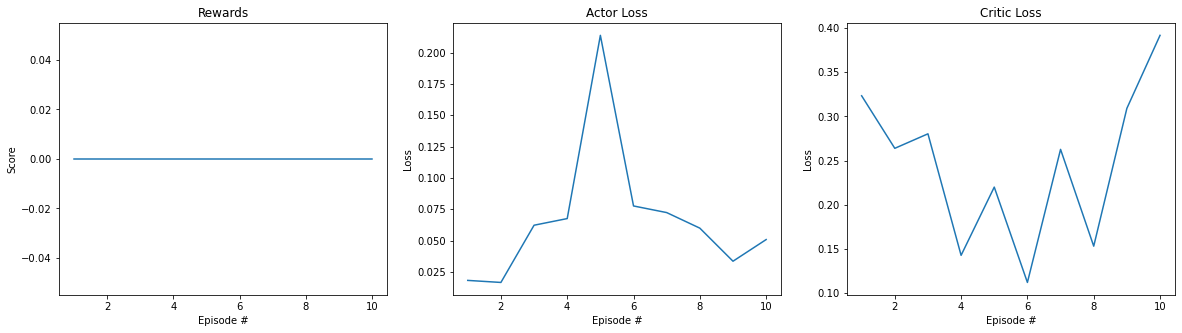

TOTAL TRAINING DURATION: 0 days, 0 hours, 0 minutes and 7 seconds
***TRAINING STOPPED AT 2022-05-16--00:19:13 


[0,
 0,
 0,
 0,
 0,
 -0.40030576731078327,
 -0.3922712882049382,
 -0.4398014632752165,
 -0.9072588429387126,
 -0.8730963840498589]

In [17]:
##################
# QUICK TEST
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=10
params.max_t = 100
params.print_every = 2
params.save_every = 2
params.log_weights_every = 100
params.terminate_on_target_score = False
params.plot_stats = True
params.lr = 1e-4                  
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'


#### MAIN #####
logger = Logger(params)
agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)

=====  =====


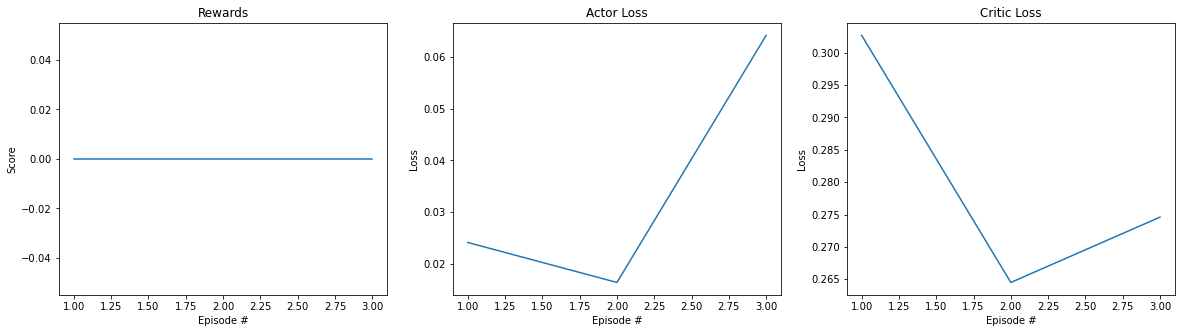

In [10]:
logger.plot_stats()

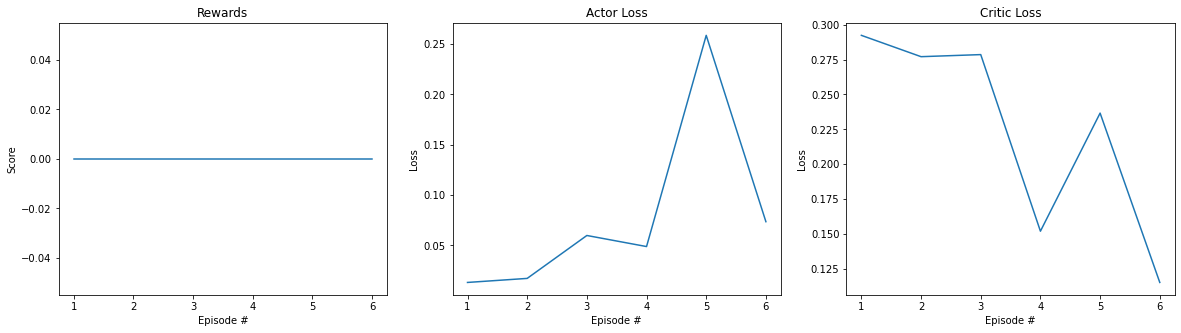

In [27]:
def plot_graph(logger):
    
    score_arr  = np.array(logger.scores_list)
    score_arr[score_arr < 0] = 0
    _, axs = plt.subplots(1, 3, figsize=(20, 5))

    # Scores
    axs[0].plot(np.arange(1, len(logger.scores_list)+1), score_arr)
    axs[0].set(xlabel='Episode #', ylabel='Score')
    axs[0].set_title('Rewards')
        
    # Actor Loss
    axs[1].plot(np.arange(1, len(logger.actor_loss_list)+1), logger.actor_loss_list)
    axs[1].set(xlabel='Episode #', ylabel='Loss')
    axs[1].set_title('Actor Loss')
    
    # Critic Loss
    axs[2].plot(np.arange(1, len(logger.critic_loss_list)+1), logger.critic_loss_list)
    axs[2].set(xlabel='Episode #', ylabel='Loss')
    axs[2].set_title('Critic Loss')
    plt.show()
    
plot_graph(logger)

In [ ]:
##################
# LONGER TEST
# NOTE: ACTUALLY DECAYING STD_SCALE PARAM
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=10000
params.max_t = 900       # Max steps per eps = 1000
params.print_every = 10
params.save_every = 20
params.log_weights_every = 100
params.terminate_on_target_score = False
params.plot_stats = True
params.lr = 1e-4                  
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'


#### MAIN #####
tb=CustomSummaryWriter()
logger = Logger(params, tb=tb)
agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  0
BATCH_SIZE:  1024
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
LR (Joint):  0.0001
GAMMA:  0.95
BETA:  0.01
BETA_DECAY:  0.9975
BETA_MIN:  0.0
EPS:  0.1
EPS_DECAY:  0.995
EPS_MIN:  0.0
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.99
GRAD_CLIP:  1.0

***STARTED TRAINING AT 2022-04-17--19:14:46 

Episode 10: 	Actor Loss: 0.06 	Critic Loss: 0.69 
		Average Score: 45.22

Episode 20: 	Actor Loss: 0.04 	Critic Loss: 0.82 
		Average Score: 56.29

Episode 30: 	Actor Loss: 0.31 	Critic Loss: 3.38 
		Average Score: 117.90

Episode 40: 	Actor Loss: 0.30 	Critic Loss: 15.91 
		Average Score: 285.59

Episode 50: 	Actor Loss: 0.27 	Critic Loss: 25.89 
		Average Score: 368.85

Episode 60: 	Actor Loss: 0.48 	Critic Loss: 40.11 
		Average Score: 421.72

Episode 70: 	Actor Loss: 0.36 	Critic Loss: 29.64 
		Average Score: 400.96

Episode 80: 	Actor Loss: 0.24 	Critic Loss: 19.94 
		Average Sc

Episode 1040: 	Actor Loss: 0.35 	Critic Loss: 0.49 
		Average Score: 32.58

Episode 1050: 	Actor Loss: 0.36 	Critic Loss: 0.18 
		Average Score: 43.62

Episode 1060: 	Actor Loss: 0.35 	Critic Loss: 0.20 
		Average Score: 40.55

Episode 1070: 	Actor Loss: 0.38 	Critic Loss: 0.34 
		Average Score: 40.63

Episode 1080: 	Actor Loss: 0.36 	Critic Loss: 0.27 
		Average Score: 40.64

Episode 1090: 	Actor Loss: 0.35 	Critic Loss: 0.19 
		Average Score: 41.19

Episode 1100: 	Actor Loss: 0.38 	Critic Loss: 0.19 
		Average Score: 40.19

Episode 1110: 	Actor Loss: 0.37 	Critic Loss: 0.35 
		Average Score: 36.64

Episode 1120: 	Actor Loss: 0.39 	Critic Loss: 0.61 
		Average Score: 38.70

Episode 1130: 	Actor Loss: 0.33 	Critic Loss: 0.28 
		Average Score: 38.36

Episode 1140: 	Actor Loss: 0.33 	Critic Loss: 0.17 
		Average Score: 38.94

Episode 1150: 	Actor Loss: 0.33 	Critic Loss: 0.23 
		Average Score: 38.10

Episode 1160: 	Actor Loss: 0.34 	Critic Loss: 0.27 
		Average Score: 40.17

Episode 1170


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  0
BATCH_SIZE:  1024
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
LR (Joint):  0.0001
GAMMA:  0.95
BETA:  0.01
BETA_DECAY:  0.9975
BETA_MIN:  0.0
EPS:  0.1
EPS_DECAY:  0.995
EPS_MIN:  0.0
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.99
GRAD_CLIP:  1.0

***STARTED TRAINING AT 2022-05-03--01:02:31 

Episode 10: 	Actor Loss: 0.06 	Critic Loss: 0.71 
		Average Score: 50.88 	 Steps: 1002

Episode 20: 	Actor Loss: 0.04 	Critic Loss: 0.80 
		Average Score: 63.09 	 Steps: 1002

Episode 30: 	Actor Loss: 0.11 	Critic Loss: 1.64 
		Average Score: 104.85 	 Steps: 1002

Episode 40: 	Actor Loss: 0.34 	Critic Loss: 1.93 
		Average Score: 1107.62 	 Steps: 10000

Episode 45	 Score: 2148.18 	 Steps: 10000

==== An exception occurred: 
=====  =====


KeyboardInterrupt: 

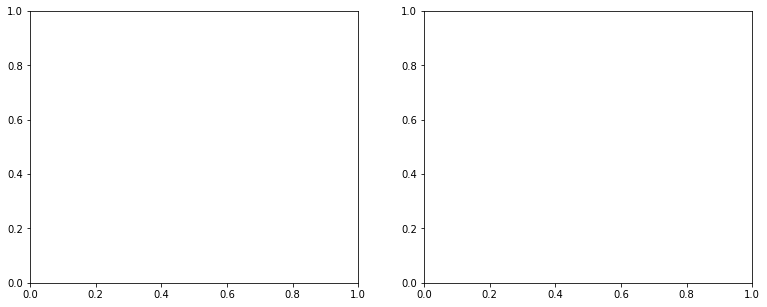

In [34]:
##################
# LONGER TEST
# NOTE: ACTUALLY DECAYING STD_SCALE PARAM
# TEST: DON'T RESET SCORES WHEN AGENT IS 'DONE'
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=10000
params.max_t = 10000       # Max steps per eps = 1000
params.print_every = 10
params.save_every = 20
params.log_weights_every = 100
params.terminate_on_target_score = False
params.plot_stats = True
params.lr = 1e-4                  
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'


#### MAIN #####
tb=CustomSummaryWriter()
logger = Logger(params, tb=tb)
agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)

In [60]:
##################
# LONGER TEST
# NOTE: ACTUALLY DECAYING STD_SCALE PARAM
# TEST: Retain score of agent from start till it falls. Avg score accumulated in deque is taken.
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=10000
params.max_t = 10000       # Max steps per eps = 1000
params.print_every = 10
params.save_every = 20
params.log_weights_every = 100
params.terminate_on_target_score = False
params.plot_stats = True
params.lr = 1e-4                  
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'


#### MAIN #####
tb=CustomSummaryWriter()
logger = Logger(params, tb=tb)
agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  0
BATCH_SIZE:  1024
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
LR (Joint):  0.0001
GAMMA:  0.95
BETA:  0.01
BETA_DECAY:  0.9975
BETA_MIN:  0.0
EPS:  0.1
EPS_DECAY:  0.995
EPS_MIN:  0.0
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.99
GRAD_CLIP:  1.0

***STARTED TRAINING AT 2022-05-03--11:35:38 

Episode 10: 	Actor Loss: 0.06 	Critic Loss: 0.33 teps: 1003
		Running Avg Score [100eps]: 49.61 	 Steps: 1003

Episode 20: 	Actor Loss: 0.05 	Critic Loss: 0.34 teps: 1003
		Running Avg Score [100eps]: 59.53 	 Steps: 1003

Episode 30: 	Actor Loss: 0.09 	Critic Loss: 0.50 teps: 100000
		Running Avg Score [100eps]: 56.11 	 Steps: 10000

Episode 40: 	Actor Loss: 0.21 	Critic Loss: 1.15 Steps: 1003
		Running Avg Score [100eps]: 140.65 	 Steps: 1003

Episode 50: 	Actor Loss: 0.23 	Critic Loss: 3.21 Steps: 10030
		Running Avg Score [100eps]: 371.18 	 Steps: 1003

Episode 60: 	Actor Loss: 0.

KeyboardInterrupt: 

In [30]:
##################
# LONGER TEST
# NOTE: ACTUALLY DECAYING STD_SCALE PARAM
# TEST: Retain score of agent from start till it falls. Avg score accumulated in deque is taken.
# DEcaying LR
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=10000
params.max_t = 10000       # Max steps per eps = 1000
params.print_every = 10
params.save_every = 20
params.log_weights_every = 100
params.terminate_on_target_score = False
params.plot_stats = True
params.lr = 1e-4                  
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'


#### MAIN #####
tb=CustomSummaryWriter()
logger = Logger(params, tb=tb)
agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  0
BATCH_SIZE:  1024
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
GAMMA:  0.95
LR (Joint):  0.0001
LR_DECAY:  0.995
LR_MIN:  1e-05
BETA:  0.01
BETA_DECAY:  0.9975
BETA_MIN:  0.0
EPS:  0.1
EPS_DECAY:  0.995
EPS_MIN:  0.0
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.99
GRAD_CLIP:  1.0

***STARTED TRAINING AT 2022-05-03--14:28:04 

Episode 10: 	Actor Loss: 0.06 	Critic Loss: 0.33 
		Avg Score [100eps]: 49.97 	 Steps: 1002

Episode 20: 	Actor Loss: 0.05 	Critic Loss: 0.34 
		Avg Score [100eps]: 57.54 	 Steps: 1002

Episode 30: 	Actor Loss: 0.09 	Critic Loss: 0.46 9
		Avg Score [100eps]: 104.41 	 Steps: 9999

Episode 40: 	Actor Loss: 0.14 	Critic Loss: 0.70 2
		Avg Score [100eps]: 67.98 	 Steps: 1002

Episode 44	 Score [This Eps]: 144.32 	 Steps: 9999NaN next_states Found! Skipping this episode.

NaN found in states. Skipping this episode.

NaN found in states. Skipping this episod

KeyboardInterrupt: 

In [33]:
##################
# LONGER TEST
# NOTE: ACTUALLY DECAYING STD_SCALE PARAM
# TEST: Retain score of agent from start till it falls. Avg score accumulated in deque is taken.
# DEcaying LR
# std input: 0.3
# std_scale hard_tanh max = 0.5*std_scale
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=10000
params.max_t = 2048       # Max steps per eps = 1000
params.print_every = 10
params.save_every = 20
params.log_weights_every = 100
params.terminate_on_target_score = False
params.plot_stats = True
params.lr = 1e-4                  
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'


#### MAIN #####
tb=CustomSummaryWriter()
logger = Logger(params, tb=tb)
agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  0
BATCH_SIZE:  1024
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
GAMMA:  0.95
LR (Joint):  0.0001
LR_DECAY:  0.995
LR_MIN:  1e-05
BETA:  0.01
BETA_DECAY:  0.9975
BETA_MIN:  0.0
EPS:  0.1
EPS_DECAY:  0.995
EPS_MIN:  0.0
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.99
GRAD_CLIP:  1.0

***STARTED TRAINING AT 2022-05-03--18:42:50 

Episode 10: 	Actor Loss: 0.06 	Critic Loss: 0.27 
		Avg Score [100eps]: 16.67 	 Steps: 2047

Episode 20: 	Actor Loss: 0.05 	Critic Loss: 0.25 
		Avg Score [100eps]: 25.56 	 Steps: 2047

Episode 30: 	Actor Loss: 0.06 	Critic Loss: 0.25 
		Avg Score [100eps]: 40.25 	 Steps: 2047

Episode 40: 	Actor Loss: 0.06 	Critic Loss: 0.27 
		Avg Score [100eps]: 53.84 	 Steps: 2047

Episode 50: 	Actor Loss: 0.07 	Critic Loss: 0.32 
		Avg Score [100eps]: 83.67 	 Steps: 2047

Episode 60: 	Actor Loss: 0.07 	Critic Loss: 0.48 7
		Avg Score [100eps]: 119.49 	 Steps: 2047

KeyboardInterrupt: 

In [35]:
##################
# LONGER TEST
# NOTE: ACTUALLY DECAYING STD_SCALE PARAM
# TEST: Retain score of agent from start till it falls. Avg score accumulated in deque is taken.
# DEcaying LR
# Increase clipping ratio coeff (eps) to 0.2
# Increase eps_min to 0.05
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=10000
params.max_t = 2048       # Max steps per eps = 1000
params.print_every = 10
params.save_every = 20
params.log_weights_every = 100
params.terminate_on_target_score = False
params.plot_stats = True
params.lr = 1e-4                  
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'


#### MAIN #####
tb=CustomSummaryWriter()
logger = Logger(params, tb=tb)
agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  0
BATCH_SIZE:  1024
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
GAMMA:  0.95
LR (Joint):  0.0001
LR_DECAY:  0.995
LR_MIN:  1e-05
BETA:  0.01
BETA_DECAY:  0.9975
BETA_MIN:  0.0
EPS:  0.2
EPS_DECAY:  0.995
EPS_MIN:  0.05
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.99
GRAD_CLIP:  1.0

***STARTED TRAINING AT 2022-05-04--00:44:07 

Episode 10: 	Actor Loss: 0.06 	Critic Loss: 0.27 
		Avg Score [100eps]: 15.61 	 Steps: 2047

Episode 20: 	Actor Loss: 0.06 	Critic Loss: 0.26 
		Avg Score [100eps]: 35.72 	 Steps: 2047

Episode 30: 	Actor Loss: 0.08 	Critic Loss: 0.39 
		Avg Score [100eps]: 88.84 	 Steps: 2047

Episode 40: 	Actor Loss: 0.13 	Critic Loss: 0.70 7
		Avg Score [100eps]: 104.92 	 Steps: 2047

Episode 50: 	Actor Loss: 0.15 	Critic Loss: 0.96 7
		Avg Score [100eps]: 178.89 	 Steps: 2047

Episode 60: 	Actor Loss: 0.15 	Critic Loss: 1.00 2
		Avg Score [100eps]: 121.26 	 Steps:

KeyboardInterrupt: 

In [36]:
##################
# LONGER TEST
# NOTE: ACTUALLY DECAYING STD_SCALE PARAM
# TEST: Retain score of agent from start till it falls. Avg score accumulated in deque is taken.
# DEcaying LR
# Increase eps_decay and std_scale_decay to 0.9975
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=10000
params.max_t = 2048       # Max steps per eps = 1000
params.print_every = 10
params.save_every = 20
params.log_weights_every = 100
params.terminate_on_target_score = False
params.plot_stats = True
params.lr = 1e-4                  
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'


#### MAIN #####
tb=CustomSummaryWriter()
logger = Logger(params, tb=tb)
agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  0
BATCH_SIZE:  1024
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
GAMMA:  0.95
LR (Joint):  0.0001
LR_DECAY:  0.995
LR_MIN:  1e-05
BETA:  0.01
BETA_DECAY:  0.9975
BETA_MIN:  0.0
EPS:  0.2
EPS_DECAY:  0.9975
EPS_MIN:  0.05
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.99
GRAD_CLIP:  1.0

***STARTED TRAINING AT 2022-05-04--02:47:15 

Episode 10: 	Actor Loss: 0.05 	Critic Loss: 0.27 
		Avg Score [100eps]: 15.14 	 Steps: 2047

Episode 20: 	Actor Loss: 0.05 	Critic Loss: 0.26 
		Avg Score [100eps]: 37.07 	 Steps: 2047

Episode 30: 	Actor Loss: 0.06 	Critic Loss: 0.36 
		Avg Score [100eps]: 78.34 	 Steps: 2047

Episode 40: 	Actor Loss: 0.10 	Critic Loss: 0.50 7
		Avg Score [100eps]: 116.13 	 Steps: 2047

Episode 50: 	Actor Loss: 0.10 	Critic Loss: 0.79 7
		Avg Score [100eps]: 150.11 	 Steps: 2047

Episode 60: 	Actor Loss: 0.11 	Critic Loss: 1.01 7
		Avg Score [100eps]: 169.59 	 Steps

Episode 1640: 	Actor Loss: 0.44 	Critic Loss: 22.08 
		Avg Score [100eps]: 236.39 	 Steps: 2047

Episode 1650: 	Actor Loss: 0.44 	Critic Loss: 22.32 
		Avg Score [100eps]: 311.19 	 Steps: 2047

Episode 1660: 	Actor Loss: 0.43 	Critic Loss: 22.13 
		Avg Score [100eps]: 562.56 	 Steps: 2047

Episode 1670: 	Actor Loss: 0.42 	Critic Loss: 22.07 
		Avg Score [100eps]: 595.87 	 Steps: 2047

Episode 1680: 	Actor Loss: 0.42 	Critic Loss: 21.96 
		Avg Score [100eps]: 666.07 	 Steps: 1002

Episode 1690: 	Actor Loss: 0.42 	Critic Loss: 18.41 
		Avg Score [100eps]: 360.50 	 Steps: 2047

Episode 1700: 	Actor Loss: 0.40 	Critic Loss: 15.34 
		Avg Score [100eps]: 185.15 	 Steps: 2047

Episode 1710: 	Actor Loss: 0.40 	Critic Loss: 12.72 
		Avg Score [100eps]: 213.39 	 Steps: 2047

Episode 1720: 	Actor Loss: 0.40 	Critic Loss: 8.65 7
		Avg Score [100eps]: 310.94 	 Steps: 2047

Episode 1730: 	Actor Loss: 0.40 	Critic Loss: 4.99 7
		Avg Score [100eps]: 380.59 	 Steps: 2047

Episode 1740: 	Actor Loss: 0.3

KeyboardInterrupt: 

In [37]:
##################
# LONGER TEST
# NOTE: ACTUALLY DECAYING STD_SCALE PARAM
# TEST: Retain score of agent from start till it falls. Avg score accumulated in deque is taken.
# DEcaying LR
# Set all params decay rate (except for LR to be 1.0 - don't decay)
# RESULTS: WORSE OFF
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=10000
params.max_t = 2048       # Max steps per eps = 1000
params.print_every = 10
params.save_every = 20
params.log_weights_every = 100
params.terminate_on_target_score = False
params.plot_stats = True
params.lr = 1e-4                  
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'


#### MAIN #####
tb=CustomSummaryWriter()
logger = Logger(params, tb=tb)
agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  0
BATCH_SIZE:  1024
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
GAMMA:  0.95
LR (Joint):  0.0001
LR_DECAY:  0.995
LR_MIN:  1e-05
BETA:  0.01
BETA_DECAY:  1.0
BETA_MIN:  0.0
EPS:  0.2
EPS_DECAY:  1.0
EPS_MIN:  0.05
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.99
GRAD_CLIP:  1.0

***STARTED TRAINING AT 2022-05-04--09:45:03 

Episode 10: 	Actor Loss: 0.05 	Critic Loss: 0.27 
		Avg Score [100eps]: 14.46 	 Steps: 2047

Episode 20: 	Actor Loss: 0.05 	Critic Loss: 0.25 
		Avg Score [100eps]: 30.07 	 Steps: 2047

Episode 30: 	Actor Loss: 0.06 	Critic Loss: 0.30 
		Avg Score [100eps]: 55.95 	 Steps: 2047

Episode 40: 	Actor Loss: 0.07 	Critic Loss: 0.43 7
		Avg Score [100eps]: 108.67 	 Steps: 2047

Episode 50: 	Actor Loss: 0.09 	Critic Loss: 0.60 7
		Avg Score [100eps]: 111.39 	 Steps: 2047

Episode 60: 	Actor Loss: 0.10 	Critic Loss: 0.77 7
		Avg Score [100eps]: 145.25 	 Steps: 2047

KeyboardInterrupt: 

In [ ]:
##################
# LONGER TEST
# NOTE: ACTUALLY DECAYING STD_SCALE PARAM
# TEST: Retain score of agent from start till it falls. Avg score accumulated in deque is taken.
# DEcaying LR
# Set all params decay rate (except for LR to be 1.0 - don't decay)
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=10000
params.max_t = 2048       # Max steps per eps = 1000
params.print_every = 10
params.save_every = 20
params.log_weights_every = 100
params.terminate_on_target_score = False
params.plot_stats = True
params.lr = 1e-4                  
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'
params.gae_tau = 0.90

#### MAIN #####
tb=CustomSummaryWriter()
logger = Logger(params, tb=tb)
agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)


============  HYPERPARAMS ============
DEVICE:  cpu
RANDOM SEED:  0
BATCH_SIZE:  1024
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
GAMMA:  0.95
LR (Joint):  0.0001
LR_DECAY:  0.995
LR_MIN:  1e-05
BETA:  0.01
BETA_DECAY:  0.9975
BETA_MIN:  0.0
EPS:  0.2
EPS_DECAY:  0.9975
EPS_MIN:  0.05
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.9
GRAD_CLIP:  1.0

***STARTED TRAINING AT 2022-05-04--14:27:09 

Episode 10: 	Actor Loss: 0.05 	Critic Loss: 0.30 
		Avg Score [100eps]: 33.23 	 Steps: 2047

Episode 20: 	Actor Loss: 0.10 	Critic Loss: 2.57 7
		Avg Score [100eps]: 181.66 	 Steps: 2047

Episode 30: 	Actor Loss: 0.14 	Critic Loss: 5.15 0
		Avg Score [100eps]: 288.22 	 Steps: 1000

Episode 40: 	Actor Loss: 0.15 	Critic Loss: 6.97 7
		Avg Score [100eps]: 330.52 	 Steps: 2047

Episode 50: 	Actor Loss: 0.16 	Critic Loss: 8.80 7
		Avg Score [100eps]: 308.96 	 Steps: 2047

Episode 60: 	Actor Loss: 0.19 	Critic Loss: 9.97 7
		Avg Score [100eps]: 317.72 	 Steps

In [8]:
##################
# LONGER TEST
# NOTE: ACTUALLY DECAYING STD_SCALE PARAM
# TEST: Retain score of agent from start till it falls. Avg score accumulated in deque is taken.
# DEcaying LR
# Model min hardtanh = 0.1
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=10000
params.max_t = 2048       # Max steps per eps = 1000
params.print_every = 10
params.save_every = 20
params.log_weights_every = 100
params.terminate_on_target_score = False
params.plot_stats = True
params.lr = 1e-4                  
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'
params.gae_tau = 0.95
params.critic_loss_coeff = 0.25

#### MAIN #####
tb=CustomSummaryWriter()
logger = Logger(params, tb=tb)
agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  0
BATCH_SIZE:  1024
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
GAMMA:  0.95
LR (Joint):  0.0001
LR_DECAY:  0.995
LR_MIN:  1e-05
BETA:  0.01
BETA_DECAY:  0.9975
BETA_MIN:  0.0
EPS:  0.2
EPS_DECAY:  0.9975
EPS_MIN:  0.05
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.95
GRAD_CLIP:  1.0

***STARTED TRAINING AT 2022-05-04--20:46:04 

Episode 10: 	Actor Loss: 0.05 	Critic Loss: 0.15 
		Avg Score [100eps]: 31.05 	 Steps: 2047

Episode 20: 	Actor Loss: 0.06 	Critic Loss: 0.48 7
		Avg Score [100eps]: 162.32 	 Steps: 2047

Episode 30: 	Actor Loss: 0.11 	Critic Loss: 1.50 7
		Avg Score [100eps]: 243.61 	 Steps: 2047

Episode 40: 	Actor Loss: 0.15 	Critic Loss: 2.31 7
		Avg Score [100eps]: 275.90 	 Steps: 2047

Episode 50: 	Actor Loss: 0.16 	Critic Loss: 2.64 7
		Avg Score [100eps]: 297.37 	 Steps: 2047

Episode 60: 	Actor Loss: 0.16 	Critic Loss: 3.12 7
		Avg Score [100eps]: 291.75 	 S

Episode 1620: 	Actor Loss: 0.45 	Critic Loss: 0.72 0
		Avg Score [100eps]: 680.02 	 Steps: 1000

Episode 1630: 	Actor Loss: 0.44 	Critic Loss: 0.78 0
		Avg Score [100eps]: 753.22 	 Steps: 1000

Episode 1640: 	Actor Loss: 0.42 	Critic Loss: 0.80 0
		Avg Score [100eps]: 688.38 	 Steps: 1000

Episode 1650: 	Actor Loss: 0.38 	Critic Loss: 0.83 0
		Avg Score [100eps]: 616.24 	 Steps: 1000

Episode 1660: 	Actor Loss: 0.38 	Critic Loss: 0.86 0
		Avg Score [100eps]: 635.83 	 Steps: 1000

Episode 1670: 	Actor Loss: 0.38 	Critic Loss: 0.90 7
		Avg Score [100eps]: 637.35 	 Steps: 2047

Episode 1680: 	Actor Loss: 0.39 	Critic Loss: 0.93 7
		Avg Score [100eps]: 543.54 	 Steps: 2047

Episode 1690: 	Actor Loss: 0.39 	Critic Loss: 0.96 7
		Avg Score [100eps]: 573.51 	 Steps: 2047

Episode 1700: 	Actor Loss: 0.39 	Critic Loss: 0.95 7
		Avg Score [100eps]: 595.06 	 Steps: 2047

Episode 1710: 	Actor Loss: 0.39 	Critic Loss: 0.95 7
		Avg Score [100eps]: 688.57 	 Steps: 2047

Episode 1720: 	Actor Loss: 0.3

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "C:\Users\derek\anaconda3\envs\drlnd_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-0145d7a6a6a1>", line 30, in <module>
    ppo(params, logger)
  File "<ipython-input-7-c11e12c69666>", line 27, in ppo
    actions, log_probs, _, values = agent.act(states, agent.std_scale)
  File "scripts\ppo_agent.py", line 70, in act
    action, log_prob, entropy, value = self.ppo_ac_net(state, std_scale=std_scale)  # stdev cannot = 0
  File "C:\Users\derek\anaconda3\envs\drlnd_gpu\lib\site-packages\torch\nn\modules\module.py", line 1051, in _call_impl
    return forward_call(*input, **kwargs)
  File "scripts\model.py", line 260, in forward
    v = self.critic(s, action)
  File "C:\Users\derek\anaconda3\envs\drlnd_gpu\lib\site-packages\torch\nn\modules\module.py", line 1051, in _call_impl
    return forward_call(*input, **kwargs)
  File "scripts\mode

TypeError: object of type 'NoneType' has no len()

In [9]:
##################
# LONGER TEST
# NOTE: ACTUALLY DECAYING STD_SCALE PARAM
# TEST: Retain score of agent from start till it falls. Avg score accumulated in deque is taken.
# DEcaying LR
# Slow down beta decay
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=10000
params.max_t = 2048       # Max steps per eps = 1000
params.print_every = 10
params.save_every = 20
params.log_weights_every = 100
params.terminate_on_target_score = False
params.plot_stats = True
params.lr = 1e-4                  
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'
params.beta_decay = 0.999                     # How fast to tighten the clipping function
params.beta_min = 0.001                       # Min eps to decay to 

#### MAIN #####
tb=CustomSummaryWriter()
logger = Logger(params, tb=tb)
agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  0
BATCH_SIZE:  1024
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
GAMMA:  0.95
LR (Joint):  0.0001
LR_DECAY:  0.995
LR_MIN:  1e-05
BETA:  0.01
BETA_DECAY:  0.999
BETA_MIN:  0.001
EPS:  0.2
EPS_DECAY:  0.9975
EPS_MIN:  0.05
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.95
GRAD_CLIP:  1.0

***STARTED TRAINING AT 2022-05-05--08:18:18 

Episode 10: 	Actor Loss: 0.04 	Critic Loss: 0.15 
		Avg Score [100eps]: 34.50 	 Steps: 2047

Episode 20: 	Actor Loss: 0.36 	Critic Loss: 1.01 7
		Avg Score [100eps]: 197.72 	 Steps: 2047

Episode 30: 	Actor Loss: 0.30 	Critic Loss: 2.28 7
		Avg Score [100eps]: 280.55 	 Steps: 2047

Episode 40: 	Actor Loss: 0.28 	Critic Loss: 3.26 7
		Avg Score [100eps]: 304.62 	 Steps: 2047

Episode 50: 	Actor Loss: 0.27 	Critic Loss: 3.74 7
		Avg Score [100eps]: 333.04 	 Steps: 2047

Episode 60: 	Actor Loss: 0.25 	Critic Loss: 4.03 7
		Avg Score [100eps]: 341.50 	 

Episode 790: 	Actor Loss: 0.14 	Critic Loss: 3.56 00
		Avg Score [100eps]: 1374.48 	 Steps: 1000

Episode 800: 	Actor Loss: 0.15 	Critic Loss: 3.37 47
		Avg Score [100eps]: 1324.21 	 Steps: 2047

Episode 810: 	Actor Loss: 0.21 	Critic Loss: 3.22 00
		Avg Score [100eps]: 1361.30 	 Steps: 1000

Episode 820: 	Actor Loss: 0.22 	Critic Loss: 3.33 00
		Avg Score [100eps]: 1379.98 	 Steps: 1000

Episode 830: 	Actor Loss: 0.22 	Critic Loss: 3.18 47
		Avg Score [100eps]: 1374.59 	 Steps: 2047

Episode 840: 	Actor Loss: 0.22 	Critic Loss: 3.07 00
		Avg Score [100eps]: 1389.83 	 Steps: 1000

Episode 850: 	Actor Loss: 0.23 	Critic Loss: 3.00 00
		Avg Score [100eps]: 1389.59 	 Steps: 1000

Episode 860: 	Actor Loss: 0.25 	Critic Loss: 2.97 47
		Avg Score [100eps]: 1351.93 	 Steps: 2047

Episode 870: 	Actor Loss: 0.26 	Critic Loss: 2.99 47
		Avg Score [100eps]: 1378.15 	 Steps: 2047

Episode 880: 	Actor Loss: 0.26 	Critic Loss: 2.91 00
		Avg Score [100eps]: 1254.35 	 Steps: 1000

Episode 890: 	Actor 

Episode 1587	 Score [This Eps]: 93.14 	 Steps: 20477

KeyboardInterrupt: 

In [12]:
##################
# LONGER TEST
# NOTE: ACTUALLY DECAYING STD_SCALE PARAM
# TEST: Retain score of agent from start till it falls. Avg score accumulated in deque is taken.
# Increase max_t
# Grad clip = disabled (DOESN'T WORK)
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=10000
params.max_t = 6144       # Max steps per eps = 1000
params.print_every = 10
params.save_every = 20
params.log_weights_every = 100
params.terminate_on_target_score = False
params.plot_stats = True
params.lr = 1e-4                  
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'
params.gradient_clip = int(0)

#### MAIN #####
tb=CustomSummaryWriter()
logger = Logger(params, tb=tb)
agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  0
BATCH_SIZE:  1024
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
GAMMA:  0.95
LR (Joint):  0.0001
LR_DECAY:  0.995
LR_MIN:  1e-05
BETA:  0.01
BETA_DECAY:  0.999
BETA_MIN:  0.001
EPS:  0.2
EPS_DECAY:  0.9975
EPS_MIN:  0.05
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.95

***STARTED TRAINING AT 2022-05-05--23:18:42 

Episode 10: 	Actor Loss: 0.08 	Critic Loss: 0.14 
		Avg Score [100eps]: 17.65 	 Steps: 6143

Episode 20: 	Actor Loss: 0.06 	Critic Loss: 0.15 
		Avg Score [100eps]: 51.73 	 Steps: 6143

Episode 30: 	Actor Loss: 0.11 	Critic Loss: 0.21 
		Avg Score [100eps]: 73.54 	 Steps: 6143

Episode 40: 	Actor Loss: 0.15 	Critic Loss: 0.25 
		Avg Score [100eps]: 64.65 	 Steps: 6143

Episode 50: 	Actor Loss: 0.22 	Critic Loss: 0.28 
		Avg Score [100eps]: 40.17 	 Steps: 6143

Episode 60: 	Actor Loss: 0.30 	Critic Loss: 0.27 
		Avg Score [100eps]: 41.53 	 Steps: 6143

Episode 70: 	

KeyboardInterrupt: 

In [14]:
##################
# LONGER TEST
# NOTE: ACTUALLY DECAYING STD_SCALE PARAM
# TEST: Retain score of agent from start till it falls. Avg score accumulated in deque is taken.
# Increase max_t
# Grad clip = disabled (DOESN'T WORK)
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=10000
params.max_t = 3072       # Max steps per eps = 1000
params.print_every = 10
params.save_every = 20
params.log_weights_every = 100
params.terminate_on_target_score = False
params.plot_stats = True
params.lr = 1e-4                  
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'
params.lr_decay = 1.0

#### MAIN #####
tb=CustomSummaryWriter()
logger = Logger(params, tb=tb)
agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  0
BATCH_SIZE:  1024
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
GAMMA:  0.95
LR (Joint):  0.0001
LR_DECAY:  1.0
LR_MIN:  1e-05
BETA:  0.01
BETA_DECAY:  0.999
BETA_MIN:  0.001
EPS:  0.2
EPS_DECAY:  0.9975
EPS_MIN:  0.05
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.95
GRAD_CLIP:  1.0

***STARTED TRAINING AT 2022-05-06--11:28:58 

Episode 10: 	Actor Loss: 0.04 	Critic Loss: 0.14 
		Avg Score [100eps]: 34.53 	 Steps: 1000

Episode 20: 	Actor Loss: 0.07 	Critic Loss: 0.46 1
		Avg Score [100eps]: 167.40 	 Steps: 3071

Episode 30: 	Actor Loss: 0.17 	Critic Loss: 1.15 1
		Avg Score [100eps]: 173.11 	 Steps: 3071

Episode 40: 	Actor Loss: 0.22 	Critic Loss: 1.68 1
		Avg Score [100eps]: 248.53 	 Steps: 3071

Episode 50: 	Actor Loss: 0.27 	Critic Loss: 2.07 1
		Avg Score [100eps]: 282.07 	 Steps: 3071

Episode 60: 	Actor Loss: 0.28 	Critic Loss: 2.37 1
		Avg Score [100eps]: 294.22 	 St

KeyboardInterrupt: 

In [8]:
##################
# LONGER TEST
# NOTE: ACTUALLY DECAYING STD_SCALE PARAM
# TEST: Retain score of agent from start till it falls. Avg score accumulated in deque is taken.
# Increase std_scale_decay
# Results: Negligible outcome
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=10000
params.max_t = 3072       # Max steps per eps = 1000
params.print_every = 10
params.save_every = 20
params.log_weights_every = 100
params.terminate_on_target_score = False
params.plot_stats = True
params.lr = 1e-4                  
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'
params.std_scale_decay = 0.999

#### MAIN #####
tb=CustomSummaryWriter()
logger = Logger(params, tb=tb)
agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  0
BATCH_SIZE:  1024
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
GAMMA:  0.95
LR (Joint):  0.0001
LR_DECAY:  0.995
LR_MIN:  1e-05
BETA:  0.01
BETA_DECAY:  0.999
BETA_MIN:  0.001
EPS:  0.2
EPS_DECAY:  0.9975
EPS_MIN:  0.05
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.95
GRAD_CLIP:  1.0

***STARTED TRAINING AT 2022-05-08--01:44:27 

Episode 10: 	Actor Loss: 0.05 	Critic Loss: 0.14 
		Avg Score [100eps]: 30.83 	 Steps: 1000

Episode 20: 	Actor Loss: 0.07 	Critic Loss: 0.52 1
		Avg Score [100eps]: 176.91 	 Steps: 3071

Episode 30: 	Actor Loss: 0.11 	Critic Loss: 1.62 0
		Avg Score [100eps]: 224.39 	 Steps: 1000

Episode 40: 	Actor Loss: 0.14 	Critic Loss: 2.40 1
		Avg Score [100eps]: 303.90 	 Steps: 3071

Episode 50: 	Actor Loss: 0.16 	Critic Loss: 2.97 1
		Avg Score [100eps]: 327.74 	 Steps: 3071

Episode 53	 Score [This Eps]: 334.41 	 Steps: 3071NaN Reward Found! Skipping this 

Episode 1630: 	Actor Loss: 0.13 	Critic Loss: 1.95 00
		Avg Score [100eps]: 1471.01 	 Steps: 1000

Episode 1640: 	Actor Loss: 0.13 	Critic Loss: 1.98 71
		Avg Score [100eps]: 1277.06 	 Steps: 3071

Episode 1650: 	Actor Loss: 0.13 	Critic Loss: 2.04 71
		Avg Score [100eps]: 1307.78 	 Steps: 3071

Episode 1660: 	Actor Loss: 0.14 	Critic Loss: 2.06 71
		Avg Score [100eps]: 1412.43 	 Steps: 3071

Episode 1670: 	Actor Loss: 0.14 	Critic Loss: 2.09 71
		Avg Score [100eps]: 1412.35 	 Steps: 3071

Episode 1680: 	Actor Loss: 0.14 	Critic Loss: 2.12 71
		Avg Score [100eps]: 1195.13 	 Steps: 3071

Episode 1690: 	Actor Loss: 0.14 	Critic Loss: 2.19 71
		Avg Score [100eps]: 1325.19 	 Steps: 3071

Episode 1700: 	Actor Loss: 0.15 	Critic Loss: 2.20 71
		Avg Score [100eps]: 1063.32 	 Steps: 3071

Episode 1710: 	Actor Loss: 0.15 	Critic Loss: 2.24 71
		Avg Score [100eps]: 1185.12 	 Steps: 3071

Episode 1720: 	Actor Loss: 0.16 	Critic Loss: 2.26 71
		Avg Score [100eps]: 1254.52 	 Steps: 3071

Episode 17

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "C:\Users\derek\anaconda3\envs\drlnd_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-99096d027bf4>", line 29, in <module>
    ppo(params, logger)
  File "<ipython-input-7-c11e12c69666>", line 27, in ppo
    actions, log_probs, _, values = agent.act(states, agent.std_scale)
  File "scripts\ppo_agent.py", line 70, in act
    action, log_prob, entropy, value = self.ppo_ac_net(state, std_scale=std_scale)  # stdev cannot = 0
  File "C:\Users\derek\anaconda3\envs\drlnd_gpu\lib\site-packages\torch\nn\modules\module.py", line 1051, in _call_impl
    return forward_call(*input, **kwargs)
  File "scripts\model.py", line 257, in forward
    log_prob, _, resampled_action, entropy = self.actor(s, resampled_action=action, std_scale=std_scale)
  File "C:\Users\derek\anaconda3\envs\drlnd_gpu\lib\site-packages\torch\nn\modules\module.py", line 1051, in

TypeError: object of type 'NoneType' has no len()

In [11]:
##################
# LONGER TEST
# NOTE: ACTUALLY DECAYING STD_SCALE PARAM
# Increase starting Learning Rate
# Results: 
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=10000
params.max_t = 3072       # Max steps per eps = 1000
params.print_every = 10
params.save_every = 20
params.log_weights_every = 100
params.terminate_on_target_score = False
params.plot_stats = True                  
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'
params.lr = 1.5e-4

#### MAIN #####
tb=CustomSummaryWriter()
logger = Logger(params, tb=tb)
agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  0
BATCH_SIZE:  1024
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
GAMMA:  0.95
LR (Joint):  0.00015
LR_DECAY:  0.995
LR_MIN:  1e-05
BETA:  0.01
BETA_DECAY:  0.999
BETA_MIN:  0.001
EPS:  0.2
EPS_DECAY:  0.9975
EPS_MIN:  0.05
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.95
GRAD_CLIP:  1.0

***STARTED TRAINING AT 2022-05-08--20:40:26 

Episode 10: 	Actor Loss: 0.08 	Critic Loss: 0.16 
		Avg Score [100eps]: 65.45 	 Steps: 3071

Episode 20: 	Actor Loss: 0.19 	Critic Loss: 0.80 1
		Avg Score [100eps]: 199.17 	 Steps: 3071

Episode 30: 	Actor Loss: 0.22 	Critic Loss: 1.52 1
		Avg Score [100eps]: 327.36 	 Steps: 3071

Episode 40: 	Actor Loss: 0.24 	Critic Loss: 1.83 1
		Avg Score [100eps]: 366.82 	 Steps: 3071

Episode 50: 	Actor Loss: 0.26 	Critic Loss: 2.01 1
		Avg Score [100eps]: 311.27 	 Steps: 3071

Episode 60: 	Actor Loss: 0.29 	Critic Loss: 1.99 1
		Avg Score [100eps]: 380.85 	

KeyboardInterrupt: 

In [12]:
##################
# LONGER TEST
# NOTE: ACTUALLY DECAYING STD_SCALE PARAM
# Increase starting Learning Rate
# Results: 
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=10000
params.max_t = 4096       # Max steps per eps = 1000
params.print_every = 10
params.save_every = 20
params.log_weights_every = 100
params.terminate_on_target_score = False
params.plot_stats = True                  
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'
params.lr = 1.5e-4
params.num_steps_collect_data = 4096
params.batch_size = 2048

#### MAIN #####
tb=CustomSummaryWriter()
logger = Logger(params, tb=tb)
agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  0
BATCH_SIZE:  2048
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
GAMMA:  0.95
LR (Joint):  0.00015
LR_DECAY:  0.995
LR_MIN:  1e-05
BETA:  0.01
BETA_DECAY:  0.999
BETA_MIN:  0.001
EPS:  0.2
EPS_DECAY:  0.9975
EPS_MIN:  0.05
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.95
GRAD_CLIP:  1.0

***STARTED TRAINING AT 2022-05-09--08:30:22 

Episode 10: 	Actor Loss: 0.05 	Critic Loss: 0.14 
		Avg Score [100eps]: 50.40 	 Steps: 3071

Episode 20: 	Actor Loss: 0.14 	Critic Loss: 0.97 1
		Avg Score [100eps]: 252.01 	 Steps: 3071

Episode 30: 	Actor Loss: 0.18 	Critic Loss: 2.15 1
		Avg Score [100eps]: 287.21 	 Steps: 3071

Episode 40: 	Actor Loss: 0.19 	Critic Loss: 3.03 1
		Avg Score [100eps]: 357.20 	 Steps: 3071

Episode 50: 	Actor Loss: 0.25 	Critic Loss: 3.22 1
		Avg Score [100eps]: 385.54 	 Steps: 3071

Episode 60: 	Actor Loss: 0.24 	Critic Loss: 3.42 0
		Avg Score [100eps]: 455.49 	

Episode 1560: 	Actor Loss: 0.40 	Critic Loss: 6.99 11
		Avg Score [100eps]: 910.74 	 Steps: 3071

Episode 1570: 	Actor Loss: 0.41 	Critic Loss: 7.29 1
		Avg Score [100eps]: 286.80 	 Steps: 3071

Episode 1580: 	Actor Loss: 0.41 	Critic Loss: 7.41 1
		Avg Score [100eps]: 418.17 	 Steps: 3071

Episode 1590: 	Actor Loss: 0.41 	Critic Loss: 7.18 1
		Avg Score [100eps]: 207.48 	 Steps: 3071

Episode 1600: 	Actor Loss: 0.42 	Critic Loss: 7.28 1
		Avg Score [100eps]: 78.72 	 Steps: 3071

Episode 1608	 Score [This Eps]: 77.93 	 Steps: 3071NaN next_states Found! Skipping this episode.
Episode 1610: 	Actor Loss: 0.39 	Critic Loss: 7.30 1
		Avg Score [100eps]: 110.44 	 Steps: 3071

Episode 1620: 	Actor Loss: 0.40 	Critic Loss: 6.84 1
		Avg Score [100eps]: 143.55 	 Steps: 3071

Episode 1630: 	Actor Loss: 0.40 	Critic Loss: 6.22 
		Avg Score [100eps]: 62.47 	 Steps: 3071

Episode 1640: 	Actor Loss: 0.40 	Critic Loss: 6.01 1
		Avg Score [100eps]: 91.57 	 Steps: 3071

Episode 1650: 	Actor Loss: 0.40 	

Episode 3220: 	Actor Loss: 0.33 	Critic Loss: 0.60 1
		Avg Score [100eps]: 177.14 	 Steps: 3071

Episode 3230: 	Actor Loss: 0.33 	Critic Loss: 0.60 1
		Avg Score [100eps]: 141.40 	 Steps: 3071

Episode 3240: 	Actor Loss: 0.33 	Critic Loss: 0.59 1
		Avg Score [100eps]: 140.87 	 Steps: 3071

Episode 3250: 	Actor Loss: 0.33 	Critic Loss: 0.57 1
		Avg Score [100eps]: 137.26 	 Steps: 3071

Episode 3260: 	Actor Loss: 0.33 	Critic Loss: 0.56 1
		Avg Score [100eps]: 144.89 	 Steps: 3071

Episode 3270: 	Actor Loss: 0.33 	Critic Loss: 0.54 1
		Avg Score [100eps]: 125.20 	 Steps: 3071

Episode 3280: 	Actor Loss: 0.33 	Critic Loss: 0.51 0
		Avg Score [100eps]: 124.01 	 Steps: 1000

Episode 3290: 	Actor Loss: 0.33 	Critic Loss: 0.52 1
		Avg Score [100eps]: 110.80 	 Steps: 3071

Episode 3300: 	Actor Loss: 0.33 	Critic Loss: 0.52 0
		Avg Score [100eps]: 103.65 	 Steps: 1000

Episode 3310: 	Actor Loss: 0.33 	Critic Loss: 0.51 1
		Avg Score [100eps]: 116.54 	 Steps: 3071

Episode 3320: 	Actor Loss: 0.3

Episode 4920: 	Actor Loss: 0.22 	Critic Loss: 0.02 
		Avg Score [100eps]: 80.66 	 Steps: 1000

Episode 4930: 	Actor Loss: 0.22 	Critic Loss: 0.02 
		Avg Score [100eps]: 80.50 	 Steps: 1000

Episode 4940: 	Actor Loss: 0.22 	Critic Loss: 0.02 
		Avg Score [100eps]: 79.91 	 Steps: 1000

Episode 4950: 	Actor Loss: 0.22 	Critic Loss: 0.02 
		Avg Score [100eps]: 78.07 	 Steps: 1000

Episode 4960: 	Actor Loss: 0.22 	Critic Loss: 0.02 
		Avg Score [100eps]: 77.90 	 Steps: 1000

Episode 4970: 	Actor Loss: 0.22 	Critic Loss: 0.02 
		Avg Score [100eps]: 77.85 	 Steps: 1000

Episode 4980: 	Actor Loss: 0.22 	Critic Loss: 0.02 
		Avg Score [100eps]: 77.00 	 Steps: 1000

Episode 4990: 	Actor Loss: 0.22 	Critic Loss: 0.02 
		Avg Score [100eps]: 77.47 	 Steps: 1000

Episode 5000: 	Actor Loss: 0.22 	Critic Loss: 0.02 
		Avg Score [100eps]: 76.93 	 Steps: 1000

Episode 5010: 	Actor Loss: 0.22 	Critic Loss: 0.02 
		Avg Score [100eps]: 76.53 	 Steps: 1000

Episode 5020: 	Actor Loss: 0.22 	Critic Loss: 0.02

KeyboardInterrupt: 

In [13]:
##################
# LONGER TEST
# NOTE: ACTUALLY DECAYING STD_SCALE PARAM
# Increase starting Learning Rate
# Results: 
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=10000
params.max_t = 8192       # Max steps per eps = 1000
params.print_every = 10
params.save_every = 20
params.log_weights_every = 100
params.terminate_on_target_score = False
params.plot_stats = True                  
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'
params.lr = 1e-4
params.num_steps_collect_data = 8192
params.batch_size = 2048

#### MAIN #####
tb=CustomSummaryWriter()
logger = Logger(params, tb=tb)
agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  0
BATCH_SIZE:  2048
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
GAMMA:  0.95
LR (Joint):  0.0001
LR_DECAY:  0.995
LR_MIN:  1e-05
BETA:  0.01
BETA_DECAY:  0.999
BETA_MIN:  0.001
EPS:  0.2
EPS_DECAY:  0.9975
EPS_MIN:  0.05
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.95
GRAD_CLIP:  1.0

***STARTED TRAINING AT 2022-05-10--19:07:50 

Episode 10: 	Actor Loss: 0.04 	Critic Loss: 0.13 
		Avg Score [100eps]: 54.81 	 Steps: 8191

Episode 20: 	Actor Loss: 0.06 	Critic Loss: 0.73 1
		Avg Score [100eps]: 256.00 	 Steps: 8191

Episode 30: 	Actor Loss: 0.11 	Critic Loss: 2.06 1
		Avg Score [100eps]: 368.24 	 Steps: 8191

Episode 33	 Score [This Eps]: 398.35 	 Steps: 8191NaN next_states Found! Skipping this episode.
Episode 40: 	Actor Loss: 0.15 	Critic Loss: 2.67 1
		Avg Score [100eps]: 490.86 	 Steps: 8191

Episode 50: 	Actor Loss: 0.17 	Critic Loss: 2.90 1
		Avg Score [100eps]: 589.38 	

Episode 780: 	Actor Loss: 0.16 	Critic Loss: 3.49 00
		Avg Score [100eps]: 2047.70 	 Steps: 1000

Episode 790: 	Actor Loss: 0.16 	Critic Loss: 3.56 00
		Avg Score [100eps]: 2074.18 	 Steps: 1000

Episode 800: 	Actor Loss: 0.16 	Critic Loss: 3.59 00
		Avg Score [100eps]: 2116.26 	 Steps: 1000

Episode 810: 	Actor Loss: 0.16 	Critic Loss: 3.68 00
		Avg Score [100eps]: 2102.80 	 Steps: 1000

Episode 820: 	Actor Loss: 0.16 	Critic Loss: 3.77 00
		Avg Score [100eps]: 2181.00 	 Steps: 1000

Episode 830: 	Actor Loss: 0.20 	Critic Loss: 3.79 91
		Avg Score [100eps]: 2105.13 	 Steps: 8191

Episode 840: 	Actor Loss: 0.20 	Critic Loss: 3.79 91
		Avg Score [100eps]: 2027.07 	 Steps: 8191

Episode 850: 	Actor Loss: 0.21 	Critic Loss: 3.92 00
		Avg Score [100eps]: 2057.28 	 Steps: 1000

Episode 860: 	Actor Loss: 0.21 	Critic Loss: 3.89 00
		Avg Score [100eps]: 2167.94 	 Steps: 1000

Episode 870: 	Actor Loss: 0.21 	Critic Loss: 3.98 91
		Avg Score [100eps]: 1084.10 	 Steps: 8191

Episode 878	 Score [

KeyboardInterrupt: 

In [ ]:
##################
# LONGER TEST
# NOTE: ACTUALLY DECAYING STD_SCALE PARAM
# Increase starting Learning Rate
# Results: 
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=10000
params.max_t = 12288       # Max steps per eps = 1000
params.print_every = 10
params.save_every = 20
params.log_weights_every = 100
params.terminate_on_target_score = False
params.plot_stats = True                  
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'
params.lr = 1e-4
params.num_steps_collect_data = 12288
params.batch_size = 2048

#### MAIN #####
tb=CustomSummaryWriter()
logger = Logger(params, tb=tb)
agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  0
BATCH_SIZE:  2048
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
GAMMA:  0.95
LR (Joint):  0.0001
LR_DECAY:  0.995
LR_MIN:  1e-05
BETA:  0.01
BETA_DECAY:  0.999
BETA_MIN:  0.001
EPS:  0.2
EPS_DECAY:  0.9975
EPS_MIN:  0.05
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.95
GRAD_CLIP:  1.0

***STARTED TRAINING AT 2022-05-11--22:26:13 

Episode 10: 	Actor Loss: 0.05 	Critic Loss: 0.18 87
		Avg Score [100eps]: 102.31 	 Steps: 12287

Episode 20: 	Actor Loss: 0.59 	Critic Loss: 1.36 87
		Avg Score [100eps]: 420.92 	 Steps: 12287

Episode 30: 	Actor Loss: 0.47 	Critic Loss: 1.77 87
		Avg Score [100eps]: 512.33 	 Steps: 12287

Episode 40: 	Actor Loss: 0.43 	Critic Loss: 1.70 87
		Avg Score [100eps]: 655.65 	 Steps: 12287

Episode 50: 	Actor Loss: 0.41 	Critic Loss: 1.57 87
		Avg Score [100eps]: 725.55 	 Steps: 12287

Episode 60: 	Actor Loss: 0.41 	Critic Loss: 1.51 87
		Avg Score [100ep


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  0
BATCH_SIZE:  2048
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
GAMMA:  0.95
LR (Joint):  0.0001
LR_DECAY:  0.995
LR_MIN:  1e-05
BETA:  0.01
BETA_DECAY:  0.999
BETA_MIN:  0.001
EPS:  0.2
EPS_DECAY:  0.9975
EPS_MIN:  0.05
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.95
GRAD_CLIP:  1.0

***STARTED TRAINING AT 2022-05-18--00:48:47 

Episode 10: 	Actor Loss: 0.05 	Critic Loss: 0.21 
		Avg Score [100eps]: 99.23 	 Steps: 1000

Episode 20: 	Actor Loss: 0.21 	Critic Loss: 1.12 87
		Avg Score [100eps]: 387.98 	 Steps: 12287

Episode 30: 	Actor Loss: 0.23 	Critic Loss: 1.69 87
		Avg Score [100eps]: 604.25 	 Steps: 12287

Episode 40: 	Actor Loss: 0.24 	Critic Loss: 1.62 87
		Avg Score [100eps]: 666.36 	 Steps: 12287

Episode 50: 	Actor Loss: 0.42 	Critic Loss: 1.56 87
		Avg Score [100eps]: 791.16 	 Steps: 12287

Episode 60: 	Actor Loss: 0.38 	Critic Loss: 1.47 87
		Avg Score [100eps]: 

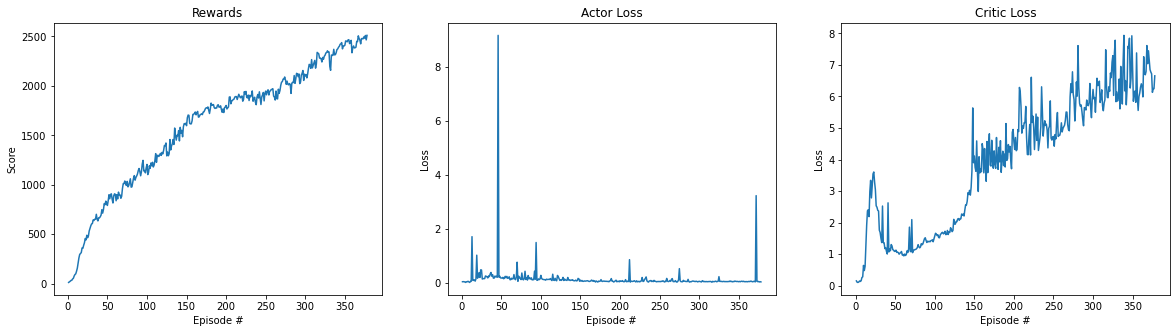

TOTAL TRAINING DURATION: 0 days, 10 hours, 37 minutes and 28 seconds
***TRAINING STOPPED AT 2022-05-18--11:26:15 


[12.228633048500487,
 18.2400571974312,
 24.426406205771926,
 32.114061766864396,
 33.867889540622784,
 47.08185033435089,
 54.167440284388725,
 77.18986785085536,
 92.22983648030315,
 99.22707708837866,
 125.40842171340584,
 156.54453393317206,
 207.45800414092315,
 259.7891941688425,
 295.39381791518247,
 305.8545136635646,
 314.5883460867545,
 361.2121475716651,
 357.89009277331354,
 387.97947297153473,
 413.6871236642619,
 456.59463547520454,
 442.6844489344547,
 489.6083101134561,
 464.2861266209092,
 482.30296573986067,
 532.6328981057089,
 559.0751754086122,
 584.4922287626797,
 604.2494776579458,
 607.4389519320265,
 644.4733045543428,
 638.763207841852,
 651.3402172196679,
 652.0868699570746,
 701.6065872943705,
 652.0409366027952,
 634.8897413625405,
 666.2061302200658,
 666.3577879690519,
 677.4928146288544,
 693.936379568025,
 747.6300698652351,
 713.4604572404464,
 748.1226031283196,
 810.0025660614785,
 798.8040839688213,
 834.6446635873941,
 810.9427482020761,
 791.15800

In [9]:
##################
# LONGER TEST
# NOTE: ACTUALLY DECAYING STD_SCALE PARAM
# Increase starting Learning Rate
# Results: 
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=1500
params.max_t = 12288       # Max steps per eps = 1000
params.print_every = 10
params.save_every = 5
params.log_weights_every = 100
params.terminate_on_target_score = True
params.target_score = 2500.0
params.plot_stats = True                  
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/final_alt'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/final_alt'
params.lr = 1e-4
params.num_steps_collect_data = 12288
params.batch_size = 2048

#### MAIN #####
tb=CustomSummaryWriter()
logger = Logger(params, tb=tb)
agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)

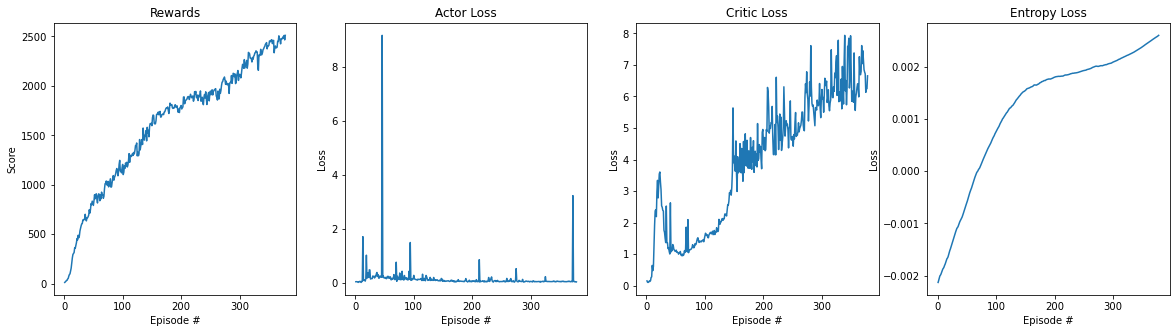

In [13]:
def plot_graph(logger):
    
    score_arr  = np.array(logger.scores_list)
    #score_arr[score_arr < 0] = 0
    _, axs = plt.subplots(1, 4, figsize=(20, 5))

    # Scores
    axs[0].plot(np.arange(1, len(logger.scores_list)+1), score_arr)
    axs[0].set(xlabel='Episode #', ylabel='Score')
    axs[0].set_title('Rewards')
        
    # Actor Loss
    axs[1].plot(np.arange(1, len(logger.actor_loss_list)+1), logger.actor_loss_list)
    axs[1].set(xlabel='Episode #', ylabel='Loss')
    axs[1].set_title('Actor Loss')
    
    # Critic Loss
    axs[2].plot(np.arange(1, len(logger.critic_loss_list)+1), logger.critic_loss_list)
    axs[2].set(xlabel='Episode #', ylabel='Loss')
    axs[2].set_title('Critic Loss')
    
    # Entropy Loss
    axs[3].plot(np.arange(1, len(logger.entropy_loss_list)+1), logger.entropy_loss_list)
    axs[3].set(xlabel='Episode #', ylabel='Loss')
    axs[3].set_title('Entropy Loss')
    plt.show()
    
plot_graph(logger)

In [22]:
# Resume Training to push agent to learn more...

# Restart training params (if restart training is false)
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/final_alt'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/final_alt'
params.restart_training = False
params.eps_to_resume_from = 381
params.actor_weights_filename_to_resume = 'checkpoint_actor_ep380.pth'
params.critic_weights_filename_to_resume = 'checkpoint_critic_ep380.pth'
params.terminate_on_target_score = False
params.target_score = 9999.0

#### MAIN #####
#tb=CustomSummaryWriter()
#logger = Logger(params, tb=tb)
#agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)

***STARTED TRAINING AT 2022-05-18--22:52:02 

Episode 390: 	Actor Loss: 0.09 	Critic Loss: 6.62 287
		Avg Score [100eps]: 2556.73 	 Steps: 12287

Episode 400: 	Actor Loss: 0.09 	Critic Loss: 6.63 007
		Avg Score [100eps]: 2686.28 	 Steps: 1000

Episode 410: 	Actor Loss: 0.09 	Critic Loss: 6.71 287
		Avg Score [100eps]: 2593.49 	 Steps: 12287

Episode 420: 	Actor Loss: 0.09 	Critic Loss: 6.77 007
		Avg Score [100eps]: 2557.67 	 Steps: 1000

Episode 430: 	Actor Loss: 0.09 	Critic Loss: 6.89 007
		Avg Score [100eps]: 2590.65 	 Steps: 1000

Episode 440: 	Actor Loss: 0.09 	Critic Loss: 6.95 287
		Avg Score [100eps]: 2675.36 	 Steps: 12287

Episode 450: 	Actor Loss: 0.06 	Critic Loss: 7.03 007
		Avg Score [100eps]: 2720.36 	 Steps: 1000

Episode 460: 	Actor Loss: 0.07 	Critic Loss: 7.25 007
		Avg Score [100eps]: 2526.71 	 Steps: 1000

Episode 470: 	Actor Loss: 0.07 	Critic Loss: 7.33 287
		Avg Score [100eps]: 2537.49 	 Steps: 12287

Episode 480: 	Actor Loss: 0.07 	Critic Loss: 7.38 287
		Avg

[12.228633048500487,
 18.2400571974312,
 24.426406205771926,
 32.114061766864396,
 33.867889540622784,
 47.08185033435089,
 54.167440284388725,
 77.18986785085536,
 92.22983648030315,
 99.22707708837866,
 125.40842171340584,
 156.54453393317206,
 207.45800414092315,
 259.7891941688425,
 295.39381791518247,
 305.8545136635646,
 314.5883460867545,
 361.2121475716651,
 357.89009277331354,
 387.97947297153473,
 413.6871236642619,
 456.59463547520454,
 442.6844489344547,
 489.6083101134561,
 464.2861266209092,
 482.30296573986067,
 532.6328981057089,
 559.0751754086122,
 584.4922287626797,
 604.2494776579458,
 607.4389519320265,
 644.4733045543428,
 638.763207841852,
 651.3402172196679,
 652.0868699570746,
 701.6065872943705,
 652.0409366027952,
 634.8897413625405,
 666.2061302200658,
 666.3577879690519,
 677.4928146288544,
 693.936379568025,
 747.6300698652351,
 713.4604572404464,
 748.1226031283196,
 810.0025660614785,
 798.8040839688213,
 834.6446635873941,
 810.9427482020761,
 791.15800

In [23]:
# Resume Training to push agent to learn more...
# RESULT: Max score = 2850

# Restart training params (if restart training is false)
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/final_alt'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/final_alt'
params.restart_training = False
params.eps_to_resume_from = 491
params.actor_weights_filename_to_resume = 'checkpoint_actor_ep490.pth'
params.critic_weights_filename_to_resume = 'checkpoint_critic_ep490.pth'
params.terminate_on_target_score = True
params.target_score = 3000.0

#### MAIN #####
#tb=CustomSummaryWriter()
#logger = Logger(params, tb=tb)
#agent = PPO_Agent(state_size, action_size, params=params)
ppo(params, logger)

***STARTED TRAINING AT 2022-05-19--00:51:54 

Episode 500: 	Actor Loss: 0.07 	Critic Loss: 7.46 007
		Avg Score [100eps]: 2627.22 	 Steps: 1000

Episode 510: 	Actor Loss: 0.07 	Critic Loss: 7.55 007
		Avg Score [100eps]: 2734.98 	 Steps: 1000

Episode 520: 	Actor Loss: 0.07 	Critic Loss: 7.63 007
		Avg Score [100eps]: 2770.43 	 Steps: 1000

Episode 530: 	Actor Loss: 0.07 	Critic Loss: 7.60 287
		Avg Score [100eps]: 2822.03 	 Steps: 12287

Episode 540: 	Actor Loss: 0.07 	Critic Loss: 7.65 007
		Avg Score [100eps]: 2777.22 	 Steps: 1000

Episode 550: 	Actor Loss: 0.07 	Critic Loss: 7.45 287
		Avg Score [100eps]: 2770.37 	 Steps: 12287

Episode 560: 	Actor Loss: 0.07 	Critic Loss: 7.38 287
		Avg Score [100eps]: 2538.79 	 Steps: 12287

Episode 563	 Score [This Eps]: 2596.90 	 Steps: 12287NaN next_states Found! Skipping this episode.
Episode 570: 	Actor Loss: 0.07 	Critic Loss: 7.36 287
		Avg Score [100eps]: 2686.83 	 Steps: 12287

Episode 580: 	Actor Loss: 0.07 	Critic Loss: 7.42 287
		Avg

[12.228633048500487,
 18.2400571974312,
 24.426406205771926,
 32.114061766864396,
 33.867889540622784,
 47.08185033435089,
 54.167440284388725,
 77.18986785085536,
 92.22983648030315,
 99.22707708837866,
 125.40842171340584,
 156.54453393317206,
 207.45800414092315,
 259.7891941688425,
 295.39381791518247,
 305.8545136635646,
 314.5883460867545,
 361.2121475716651,
 357.89009277331354,
 387.97947297153473,
 413.6871236642619,
 456.59463547520454,
 442.6844489344547,
 489.6083101134561,
 464.2861266209092,
 482.30296573986067,
 532.6328981057089,
 559.0751754086122,
 584.4922287626797,
 604.2494776579458,
 607.4389519320265,
 644.4733045543428,
 638.763207841852,
 651.3402172196679,
 652.0868699570746,
 701.6065872943705,
 652.0409366027952,
 634.8897413625405,
 666.2061302200658,
 666.3577879690519,
 677.4928146288544,
 693.936379568025,
 747.6300698652351,
 713.4604572404464,
 748.1226031283196,
 810.0025660614785,
 798.8040839688213,
 834.6446635873941,
 810.9427482020761,
 791.15800

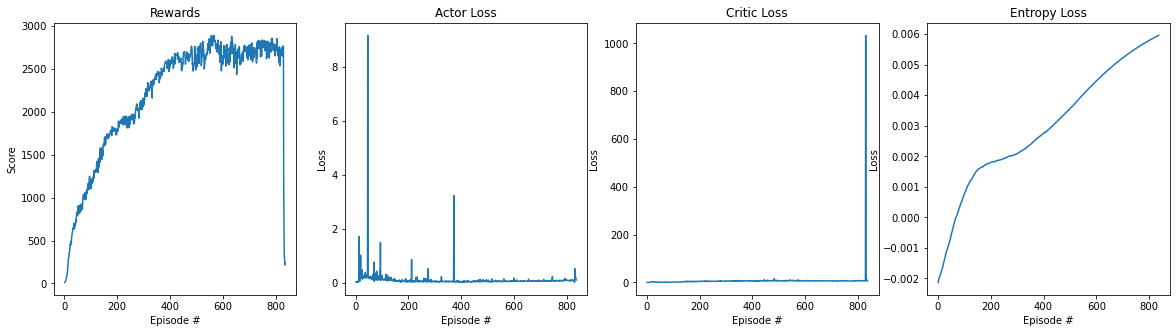

In [24]:
def plot_graph(logger):
    
    score_arr  = np.array(logger.scores_list)
    #score_arr[score_arr < 0] = 0
    _, axs = plt.subplots(1, 4, figsize=(20, 5))

    # Scores
    axs[0].plot(np.arange(1, len(logger.scores_list)+1), score_arr)
    axs[0].set(xlabel='Episode #', ylabel='Score')
    axs[0].set_title('Rewards')
        
    # Actor Loss
    axs[1].plot(np.arange(1, len(logger.actor_loss_list)+1), logger.actor_loss_list)
    axs[1].set(xlabel='Episode #', ylabel='Loss')
    axs[1].set_title('Actor Loss')
    
    # Critic Loss
    axs[2].plot(np.arange(1, len(logger.critic_loss_list)+1), logger.critic_loss_list)
    axs[2].set(xlabel='Episode #', ylabel='Loss')
    axs[2].set_title('Critic Loss')
    
    # Entropy Loss
    axs[3].plot(np.arange(1, len(logger.entropy_loss_list)+1), logger.entropy_loss_list)
    axs[3].set(xlabel='Episode #', ylabel='Loss')
    axs[3].set_title('Entropy Loss')
    plt.show()
    
plot_graph(logger)

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [31]:
# load the weights from file
params = Params()
logger = Logger(params)
agent = PPO_Agent(state_size, action_size, params=params)
agent.ppo_ac_net.actor.load_state_dict(torch.load('weights/saved/checkpoint_actor_ep770.pth'))
agent.ppo_ac_net.critic.load_state_dict(torch.load('weights/saved/checkpoint_critic_ep770.pth'))
max_t = 3000
score = np.zeros(len(env_info.agents))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment
states = env_info.vector_observations                # get the current state
score = 0                                              # initialize the score
for i in range(max_t):
    # Perform actions from each agent's policy network (clipped actions [0, -1])
    actions, _, _, _ = agent.act(states, std_scale=1e-8) 
    env_info = env.step(actions)[brain_name]         # send the action to the environment 
    next_states = env_info.vector_observations       # get the next state
    rewards = env_info.rewards                       # get the reward
    dones = env_info.local_done                      # see if episode has finished
    states = next_states                             # roll over the state to next time step
    
    # update the score
    states = next_states
    score += np.array(rewards)             
    for i in range(len(dones)):
        if dones[i]:
            logger.log_score(score[i])
            score[i] = 0
    
    # exit loop if episode finished (NOTE: Agents auto-restart upon done)
    #if all(dones):                                   
    #    break
    
print("Mean Score: {}".format(np.nanmean(logger.scores_deque)))
print("Max Score: {}".format(np.max(logger.scores_deque)))


============  HYPERPARAMS ============
DEVICE:  cuda:0
RANDOM SEED:  1
BATCH_SIZE:  2048
HIDDEN_SIZES (ACTOR):  (1024, 1024, 512)
HIDDEN_SIZES (CRITIC):  (1024, 1024, 512)
GAMMA:  0.95
LR (Joint):  0.0001
LR_DECAY:  0.995
LR_MIN:  1e-05
BETA:  0.01
BETA_DECAY:  0.999
BETA_MIN:  0.001
EPS:  0.2
EPS_DECAY:  0.9975
EPS_MIN:  0.05
WEIGHT_DECAY:  0.0001
USE GAE:  True
GAE TAU:  0.95
GRAD_CLIP:  1.0

Mean Score: 2494.7831732172053
Max Score: 2861.636207747739


When finished, you can close the environment.

In [ ]:
# env.close()